In [2]:
import numpy as np
import scipy.spatial
import matplotlib.pylab as plt
from scipy import interpolate
from IPython.display import display, HTML
from matplotlib import gridspec

In [3]:
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['font.family']="serif"
plt.rc("text", usetex=True)
plt.rc("font", size=22)

In [4]:
'''
Takes in a set of halo positions and returns the CDF of the distance to the kth nearest neighbour

halo_pos: array of shape (n_halos, 3) containing the positions of the halos
boxsize: size of the box in Mpc/h
target_number_density: the number density of halos to sample (this choice will depend on the scales of interest -
                                                              the default number density here will be for data vectors 
                                                              that are well-measured in the (rmin, rmax) range of
                                                              1-40 Mpc/h)
rmin: minimum distance in the data vector (in Mpc/h)
rmax: maximum distance in the data vector (in Mpc/h)
nbin: number of bins in the data vector
n_query_points: number of query points to use to calculate the CDF
k_list: list of k values to calculate the CDF for
'''


def get_knn_data_vector(halo_pos, boxsixe=256, 
                        target_number_density = 1e-4, rmin = 1, rmax =  40, nbin = 80,
                        n_query_points = 4000000, k_list = [1,2,3,4]):
    
    #Define the bins - equally spaced between rmin and rmax
    bins = np.linspace(rmin, rmax, nbin)
    
    #Create the data vector - CDF of query points for each k in k_list
    knn_data_vector = np.zeros((nbin, len(k_list)))
    
    #Check that the number density is correct
    n_halos = len(halo_pos)
    halo_number_density = n_halos / boxsixe**3
    print('Halo number density: ', halo_number_density)
    
    if halo_number_density>target_number_density:
        ind = np.random.choice(n_halos, int(n_halos * target_number_density / halo_number_density), replace=False)
        halo_pos = halo_pos[ind]
    
    
    query_pos = np.random.rand(n_query_points, 3) * boxsixe
    tree = scipy.spatial.cKDTree(halo_pos,boxsize=boxsixe)
    dist, ind = tree.query(query_pos, k=k_list, workers=-1)
    
    for k in k_list:
        dist_list = dist[:, k-1]
        ind = np.argsort(dist_list)
        dist_list = dist_list[ind]
        
        #Calculate the CDF at each bin
        knn_data_vector[:, k-1] = np.searchsorted(dist_list, bins) / n_query_points
        
    
    return bins, knn_data_vector

### Test 1 : Number density higher than set threshold

Use a randomly distributed set of 20000 points in the box 

In [5]:
pos = np.random.rand(50000, 3) * 256
bins, knn_data_vector = get_knn_data_vector(pos)

Halo number density:  0.0029802322387695312


(0.0, 35.0)

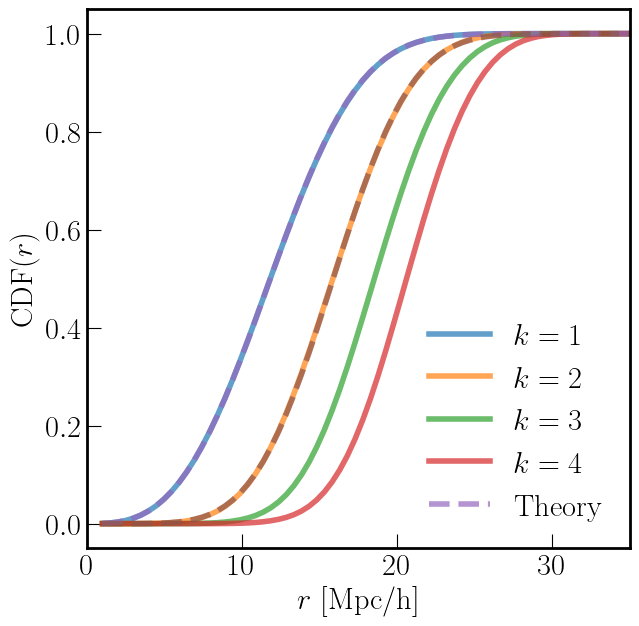

In [6]:
number_density = 1e-4

plt.plot(bins, knn_data_vector[:, 0], label=r'$k=1$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 1], label=r'$k=2$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 2], label=r'$k=3$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 3], label=r'$k=4$', lw = 4, alpha = 0.7)

plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3), label=r'Theory', lw = 4, ls = '--', alpha = 0.7)
plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3) - 
         number_density*4./3. * np.pi *bins**3 * np.exp(-number_density*4./3. * np.pi *bins**3)
         , lw = 4, ls = '--', alpha = 0.7)

plt.legend()
plt.xlabel(r'$r$ [Mpc/h]')
plt.ylabel(r'${\rm CDF}(r)$')

plt.xlim(0, 35)


### Test with a lower number density than threshold

Use 1000 points over the entire volume

In [7]:
pos = np.random.rand(1000, 3) * 256
bins, knn_data_vector = get_knn_data_vector(pos)

Halo number density:  5.9604644775390625e-05


(0.0, 35.0)

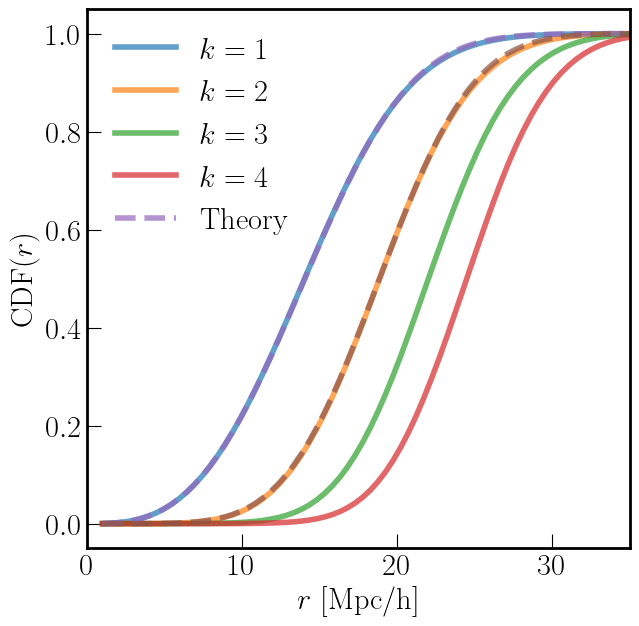

In [8]:
number_density = 1000 / 256**3

plt.plot(bins, knn_data_vector[:, 0], label=r'$k=1$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 1], label=r'$k=2$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 2], label=r'$k=3$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 3], label=r'$k=4$', lw = 4, alpha = 0.7)

plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3), label=r'Theory', lw = 4, ls = '--', alpha = 0.7)
plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3) - 
         number_density*4./3. * np.pi *bins**3 * np.exp(-number_density*4./3. * np.pi *bins**3)
         , lw = 4, ls = '--', alpha = 0.7)

plt.legend()
plt.xlabel(r'$r$ [Mpc/h]')
plt.ylabel(r'${\rm CDF}(r)$')

plt.xlim(0, 35)


### Additional check at larger boxsize

In [9]:
pos = np.random.rand(100000,3)*1000.
bins, knn_data_vector = get_knn_data_vector(pos, boxsixe=1000,)


Halo number density:  0.0001


(0.0, 35.0)

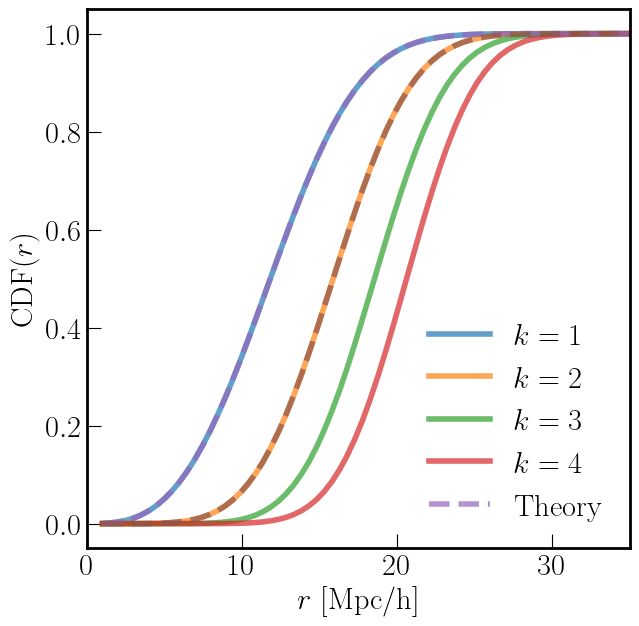

In [10]:
number_density = 1e-4

plt.plot(bins, knn_data_vector[:, 0], label=r'$k=1$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 1], label=r'$k=2$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 2], label=r'$k=3$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 3], label=r'$k=4$', lw = 4, alpha = 0.7)

plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3), label=r'Theory', lw = 4, ls = '--', alpha = 0.7)
plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3) - 
         number_density*4./3. * np.pi *bins**3 * np.exp(-number_density*4./3. * np.pi *bins**3)
         , lw = 4, ls = '--', alpha = 0.7)

plt.legend()
plt.xlabel(r'$r$ [Mpc/h]')
plt.ylabel(r'${\rm CDF}(r)$')

plt.xlim(0, 35)